## U-Nets for Image segmentation

Change Log:
* Updated figure to correct skip connections. They previously had connected to a module with the incorect dimensions.
* Removed confusing H' <= H*2 etc. from `Up` docstring.

Version: 1.2


In this assignment we will be returning to image segmentation with a new much more effective architecture. The U-Net which after being introduced in [Ronneberger et al. 2015](https://arxiv.org/abs/1505.04597) has seen wide application in everything from medical image segmentation to diffusion models.




## Helper Code

In [1]:
from typing import Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import kagglehub
import torchvision
from typing import Tuple

# Download latest version
path = kagglehub.dataset_download("farhanhubble/multimnistm2nist")

# pixel values are in the range [0, 255]
# has shape 5000 x 64 x 84
combined = np.load(path + "/combined.npy")
assert combined.shape[1:] == (64, 84), f"Expected image shape (64, 84), got {combined.shape[1:]}"

# Classes for each pixel has shape 5000 x 64 x 84 x 11
segmented = np.load(path + "/segmented.npy")
assert segmented.shape[1:] == (64, 84, 11), f"Expected mask shape (64, 84, 11), got {segmented.shape[1:]}"
segmented = np.argmax(segmented, axis=-1) # We want indecies which will be apropriate for the cross-entropy loss.

class MultiMNISTDataset(Dataset):
    def __init__(self, images: np.ndarray, targets: np.ndarray):
        """
        Args:
            images: numpy array of shape (N, H, W)
            masks: numpy array of shape (N, H, W)
        """
        assert images.ndim == 3, f"Expected 3D array for images, got shape {images.shape}"
        assert targets.ndim == 3, f"Expected 3D array for masks, got shape {targets.shape}"
        assert images.shape == targets.shape, f"Images shape {images.shape} must match masks shape {targets.shape}"

        self.images = torch.FloatTensor(images)
        self.images = F.pad(self.images, (2, 2, 0, 0), value=0)
        self.targets = torch.LongTensor(targets)
        self.targets = F.pad(self.targets, (2, 2, 0, 0), value=10)

        # Normalize images to [0, 1]
        self.images = self.images / 255.0

        # Add channel dimension to images
        self.images = self.images.unsqueeze(1)  # Shape: (N, 1, H, W)

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
            image: torch.Tensor of shape (1, H, W)
            target: torch.Tensor of shape (H, W)
        """
        return self.images[idx], self.targets[idx]
class SegmentationLoss:
    def __init__(self, use_weights: bool = False, num_classes: int = 11):
        self.use_weights = use_weights
        self.num_classes = num_classes

    def __call__(self, predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Args:
            predictions: Predicted logits of shape (B, num_classes, H, W)
            targets: Target masks of shape (B, H, W)
        Returns:
            Loss value as a scalar tensor
        """
        assert predictions.ndim == 4, f"Expected 4D predictions tensor, got shape {predictions.shape}"
        assert targets.ndim == 3, f"Expected 3D targets tensor, got shape {targets.shape}"
        assert predictions.shape[2:] == targets.shape[1:], \
            f"Shape mismatch: predictions={predictions.shape}, targets={targets.shape}"

        if self.use_weights:
            epsilon = 1e-6
            mask = torch.zeros(
                self.num_classes,
                dtype=torch.float32,
                device=predictions.device
            )
            mask.scatter_add_(
                0,
                targets.reshape(-1),
                torch.ones_like(
                    targets.reshape(-1),
                    dtype=torch.float32,
                )
            )
            weights = 1.0 / (mask + epsilon)
            weights = weights / weights.sum()

            loss = F.cross_entropy(predictions, targets, weight=weights)
        else:
            loss = F.cross_entropy(predictions, targets)
        return loss

def train_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: SegmentationLoss,
    optimizer: torch.optim.Optimizer,
    device: torch.device
) -> float:
    """
    Args:
        model: Neural network model
        dataloader: DataLoader providing (image, target) pairs
        criterion: Loss function
        optimizer: Optimization algorithm
        device: Device to run the training on
    Returns:
        Average loss for the epoch
    """
    model.train()
    total_loss = 0

    for images, targets in tqdm(dataloader, desc='Training'):
        assert images.ndim == 4, f"Expected 4D image batch, got shape {images.shape}"
        assert targets.ndim == 3, f"Expected 3D target batch, got shape {targets.shape}"

        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    num_classes: int = 11
) -> np.array:
    """
    Args:
        model: Neural network model
        dataloader: DataLoader providing (image, target) pairs
        device: Device to run the evaluation on
        num_classes: Number of segmentation classes
    Returns:
        IoU score per class averaged over the dataset
    """
    model.eval()
    iou_per_class_total = np.zeros(num_classes)


    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc='Evaluating'):
            assert images.ndim == 4, f"Expected 4D image batch, got shape {images.shape}"
            assert targets.ndim == 3, f"Expected 3D target batch, got shape {targets.shape}"

            images = images.to(device)
            targets = targets.to(device)
            one_hot_targets = F.one_hot(targets, num_classes=num_classes)

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            predictions_one_hot = F.one_hot(predictions, num_classes=num_classes)
            intersection = torch.logical_and(predictions_one_hot.bool(), one_hot_targets.bool()).float()
            union = torch.logical_or(predictions_one_hot.bool(), one_hot_targets.bool()).float()
            iou_per_class = torch.sum(intersection, dim=(0,1,2)) / (torch.sum(union, dim=(0,1,2)) + 1e-6)
            iou_per_class_total += iou_per_class.cpu().numpy()

    return iou_per_class_total / len(dataloader)

def visualize_images(
    images: list[torch.Tensor],
    ax,
    title: str = '',
    cmap: str = 'gray',
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
):
    """
    Args:
        images: List of images to visualize
    """
    images = torchvision.utils.make_grid(
        torch.cat(images),
        nrow=3
    ).numpy()[0, ...]
    ax.imshow(
        images,
        cmap=cmap,
        interpolation='nearest',
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(title)

def visualize_prediction(
    model: Optional[nn.Module],
    dataset: Dataset,
    indices: int,
    device: torch.device,
) -> None:
    """
    Args:
        model: Neural network model
        dataset: Dataset containing (image, target) pairs
        indices: Indices of the sample to visualize
        device: Device to run the inference on
    """
    model.eval()
    images = []
    predictions = []
    targets = []
    for index in indices:
        image, target = dataset[index]

        with torch.no_grad():
            image = image.unsqueeze(0).to(device)
            output = model(image)
            prediction = torch.argmax(output, dim=1, keepdim=True)
        images.append(image.cpu())
        predictions.append(prediction.cpu())
        targets.append(target[None, None, ...].cpu())

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    visualize_images(
        images=images,
        ax=axes[0],
        title='Input Images',
        cmap='grey',
        vmin=0,
        vmax=1
    )
    visualize_images(
        images=targets,
        ax=axes[1],
        title='Targets',
        cmap='tab20',
        vmin=0,
        vmax=10
    )
    visualize_images(
        images=predictions,
        ax=axes[2],
        title='Predictions',
        cmap='tab20',
        vmin=0,
        vmax=10
    )
    plt.show()

def plot_training_metrics(train_losses, val_ious):
    """
    Plot training loss and validation IoU over epochs

    Args:
        train_losses: list of training losses per epoch
        val_ious: list of validation IoUs per epoch
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot training loss
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, 'b-', marker='o')
    ax1.set_title('Training Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_ylim(bottom=0)
    ax1.grid(True)

    # Plot validation IoU
    ax2.plot(epochs, val_ious, 'g-', marker='o')
    ax2.set_title('Validation IoU Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean IoU')
    ax2.grid(True)

    # Set y-axis to start from 0 for IoU
    ax2.set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()

100%|██████████| 16.6M/16.6M [00:00<00:00, 79.4MB/s]

Extracting files...


## The Dataset

Here we will be workinging with fairly toy dataset consisting on mnist digits on a black background. Our goal will be to try to predict whether a pixel is part of a 0, 1, 2, ..., 9 or the background giving us 11 classes.

In [2]:
dataset = MultiMNISTDataset(combined, segmented)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], torch.Generator().manual_seed(42))

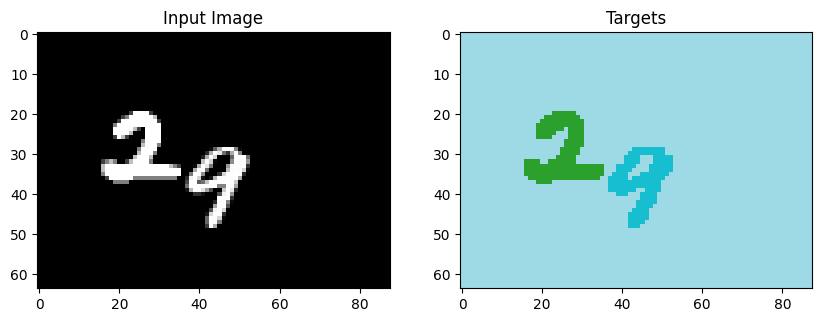

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
visualize_images([dataset[0][0]], axes[0], title='Input Image', cmap='gray', vmin=0, vmax=1)
visualize_images([dataset[0][1]], axes[1], title='Targets', cmap='tab20', vmin=0, vmax=10)

## 4.1 U-Net Implementation [1.5 pts]
Implement the unet architecture bellow. All of the standard 2d convolutions have kernel size 3. The max pooling layers and conv transpose layers should use a kernel with size 2. Note that you will need to use pading and stride to meet the dimensions in the figure bellow.


![](https://docs.google.com/drawings/d/e/2PACX-1vRyqJdmAbO6NVICEu0cnfDbBjaZ4rdkqQTQGWcsNSFZfJzNVMJgf3CiqSI5Y0pc2lrveY0dVo7jlx1n/pub?w=1324&h=1096)


In [4]:
class Down(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(Down, self).__init__()
        ### YOU'RE CODE HERE ###
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: Input tensor of shape (B, C, H, W)
        Returns:
            down: Downsampled tensor of shape (B, C_out, H/2, W/2)
            skip_connection: Skip connection tensor of shape (B, C_out, H, W) that goes
                through the convolution layers but skips the max pooling layer.
        """
        assert x.ndim == 4, f"Expected 4D input tensor, got shape {x.shape}"
        ### YOU'RE CODE HERE ####
        down = self.max_pool(self.relu(self.bn(self.conv(x))))
        skip_connection = self.relu(self.bn(self.conv(x)))

        expexted_size = tuple(s // 2 for s in x.shape[2:])
        assert down.shape[2:] == expexted_size, \
            f"Expected downsampled shape {expexted_size}, got {down.shape[2:]}"
        assert skip_connection.shape[2:] == x.shape[2:], \
            f"Expected skip connection shape {x.shape[2:]}, got {skip_connection.shape[2:]}"
        return down, skip_connection

class Up(nn.Module):
    def __init__(self, in_channels: int, skip_channels: int, out_channels: int):
        super(Up, self).__init__()
        #### YOU'RE CODE HERE ####
        self.conv = nn.Conv2d(in_channels+skip_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.block = nn.Sequential(
            self.conv,
            self.bn,
            self.relu
        )
        self.conv_transpose = nn.ConvTranspose2d(in_channels = in_channels, out_channels=in_channels, kernel_size=2, stride=2)



    def forward(self, x: torch.Tensor, skip_connection: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (B, C_in, H, W)
            skip_connection: Skip connection tensor of shape (B, C_skip, H, W)
        Returns:
            Output tensor of shape (B, C_out, H*2, W*2)
        """
        assert x.ndim == 4, f"Expected 4D input tensor, got shape {x.shape}"
        assert skip_connection.ndim == 4, f"Expected 4D skip connection tensor, got shape {skip_connection.shape}"
        expected_skip_size = tuple(2 * s for s in x.shape[2:])
        assert skip_connection.shape[2:] == expected_skip_size, \
            f"Skip connection hight {skip_connection.shape[2:]} must be {expected_skip_size}"

        ### YOU'RE CODE HERE ####
        x = self.conv_transpose(x)
        x = torch.cat((x, skip_connection), dim=1)
        x = self.block(x)

        return x

class UNet(nn.Module):
    def __init__(self, in_channels: int = 1, out_channels: int = 11, disable_skip_connections: bool = False):
        """
        Args:
            in_channels: Number of input channels
            out_channels: Number of output channels
            disable_skip_connections: Whether to set all the skip connections to zero.
        """
        super(UNet, self).__init__()

        self.disable_skip_connections = disable_skip_connections

        ### YOU'RE CODE HERE ###
        self.down1 = Down(in_channels, 64)
        self.down2 = Down(64, 128)
        self.up1 = Up(64, 128, 32)
        self.up2 = Up(32, 64, 32)
        self.final_conv = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.final_bn = nn.BatchNorm2d(64)
        self.final_relu = nn.ReLU()
        self.con_block = nn.Sequential(
            self.final_conv,
            self.final_bn,
            self.final_relu
        )
        self.final_conv2 = nn.Conv2d(32, out_channels, kernel_size=1)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (B, C, H, W)
        Returns:
            Output tensor of shape (B, num_classes, H, W)
        """
        assert x.ndim == 4, f"Expected 4D input tensor, got shape {x.shape}"
        input_shape = x.shape[2:]

        ### YOU'RE CODE HERE ###
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x= self.con_block(x)
        if self.disable_skip_connections:
          skip1 = torch.zeros_like(skip1)
          skip2 = torch.zeros_like(skip2)

        x = self.up1(x, skip2)
        x = self.up2(x, skip1)

        output = self.final_conv2(x)
        assert output.shape[2:] == input_shape, \
            f"Output shape {output.shape[2:]} must match input shape {input_shape}"
        return output

## 4.2 Train the network [1 pts]

Train the network with an without skip connections enabled. Write two or three sentences reflecting on the differences and why you belive it is happening. Include explination, an image of the final predictions made by each your network and their IoU scores for each class in your report.

  0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/24:
Training Loss: 2.0399
Validation IoU (Class: value): 0: 0.0929, 1: 0.2546, 2: 0.1129, 3: 0.1234, 4: 0.0643, 5: 0.2181, 6: 0.1862, 7: 0.1829, 8: 0.0034, 9: 0.0336, 10: 0.0000


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/24:
Training Loss: 1.2472
Validation IoU (Class: value): 0: 0.0147, 1: 0.2435, 2: 0.1845, 3: 0.0506, 4: 0.0285, 5: 0.2314, 6: 0.1568, 7: 0.1922, 8: 0.0105, 9: 0.1192, 10: 0.0217


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/24:
Training Loss: 0.8600
Validation IoU (Class: value): 0: 0.0427, 1: 0.1485, 2: 0.3390, 3: 0.0940, 4: 0.0586, 5: 0.2088, 6: 0.0872, 7: 0.1718, 8: 0.0182, 9: 0.2743, 10: 0.4839


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/24:
Training Loss: 0.6658
Validation IoU (Class: value): 0: 0.2023, 1: 0.2212, 2: 0.2647, 3: 0.1788, 4: 0.0574, 5: 0.2671, 6: 0.1576, 7: 0.2064, 8: 0.0678, 9: 0.2700, 10: 0.7262


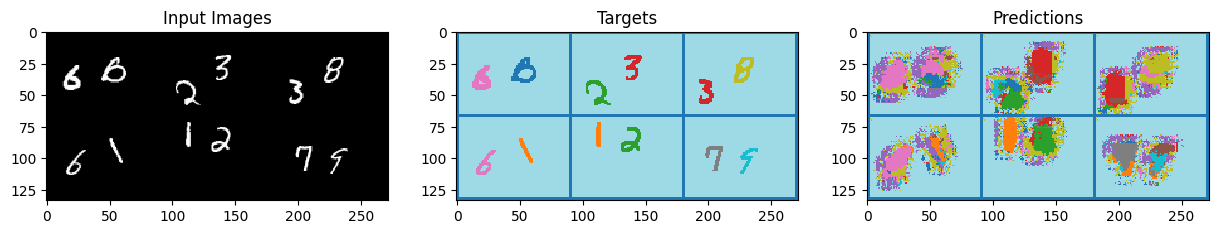

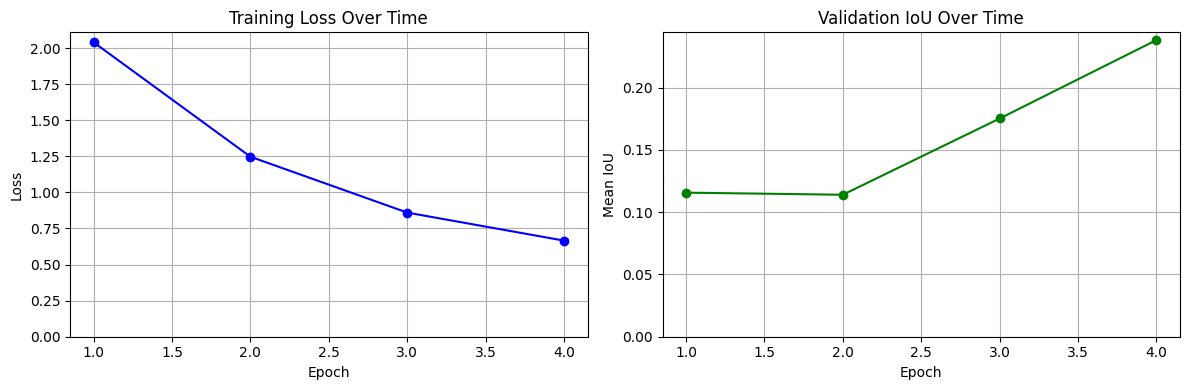

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/24:
Training Loss: 0.5632
Validation IoU (Class: value): 0: 0.2233, 1: 0.2745, 2: 0.2507, 3: 0.2204, 4: 0.1639, 5: 0.3397, 6: 0.2264, 7: 0.2675, 8: 0.1862, 9: 0.4268, 10: 0.8606


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/24:
Training Loss: 0.4942
Validation IoU (Class: value): 0: 0.3628, 1: 0.3054, 2: 0.2970, 3: 0.2042, 4: 0.2132, 5: 0.2752, 6: 0.4119, 7: 0.2482, 8: 0.3114, 9: 0.3648, 10: 0.8912


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/24:
Training Loss: 0.4395
Validation IoU (Class: value): 0: 0.3895, 1: 0.2979, 2: 0.4065, 3: 0.3093, 4: 0.2791, 5: 0.3370, 6: 0.4210, 7: 0.3127, 8: 0.3113, 9: 0.3828, 10: 0.9160


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/24:
Training Loss: 0.3926
Validation IoU (Class: value): 0: 0.3928, 1: 0.3365, 2: 0.3720, 3: 0.3402, 4: 0.3355, 5: 0.3449, 6: 0.4031, 7: 0.3403, 8: 0.3318, 9: 0.3944, 10: 0.9232


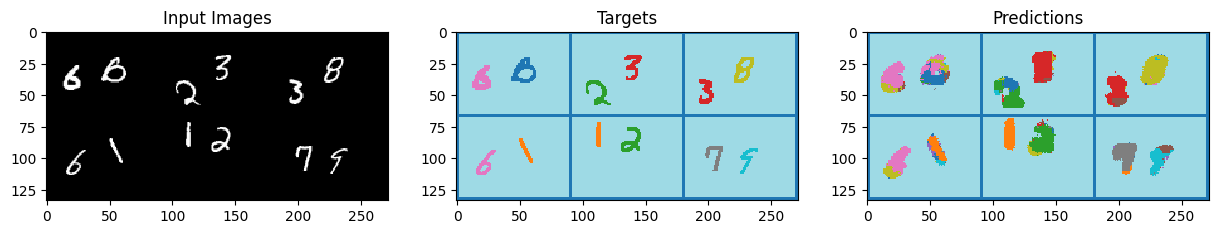

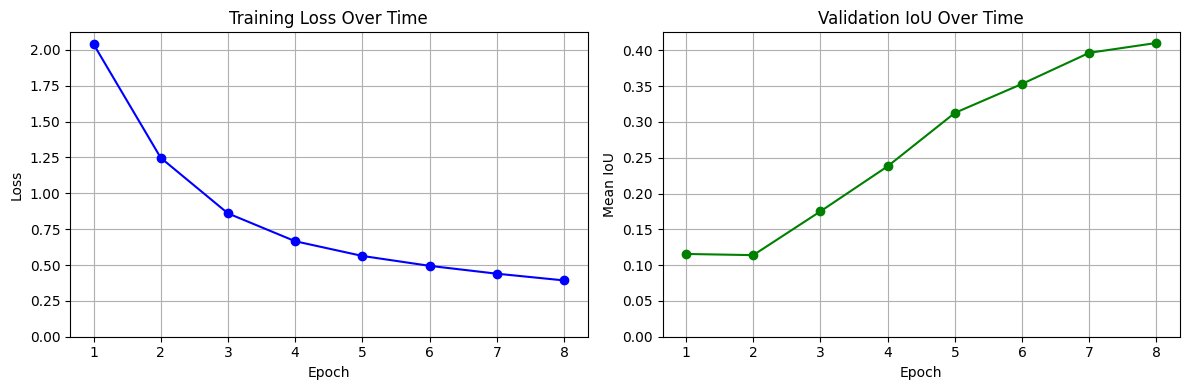

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/24:
Training Loss: 0.3458
Validation IoU (Class: value): 0: 0.3715, 1: 0.3684, 2: 0.4293, 3: 0.3702, 4: 0.3501, 5: 0.3202, 6: 0.4448, 7: 0.4055, 8: 0.3903, 9: 0.4348, 10: 0.9330


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/24:
Training Loss: 0.3046
Validation IoU (Class: value): 0: 0.4469, 1: 0.3418, 2: 0.4343, 3: 0.3906, 4: 0.3698, 5: 0.4271, 6: 0.4156, 7: 0.4186, 8: 0.4344, 9: 0.4729, 10: 0.9437


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/24:
Training Loss: 0.2773
Validation IoU (Class: value): 0: 0.4613, 1: 0.4043, 2: 0.3749, 3: 0.3900, 4: 0.4208, 5: 0.4296, 6: 0.4983, 7: 0.4137, 8: 0.4235, 9: 0.4442, 10: 0.9433


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/24:
Training Loss: 0.2477
Validation IoU (Class: value): 0: 0.4927, 1: 0.4011, 2: 0.3588, 3: 0.3275, 4: 0.3815, 5: 0.3952, 6: 0.5093, 7: 0.4100, 8: 0.4914, 9: 0.4768, 10: 0.9425


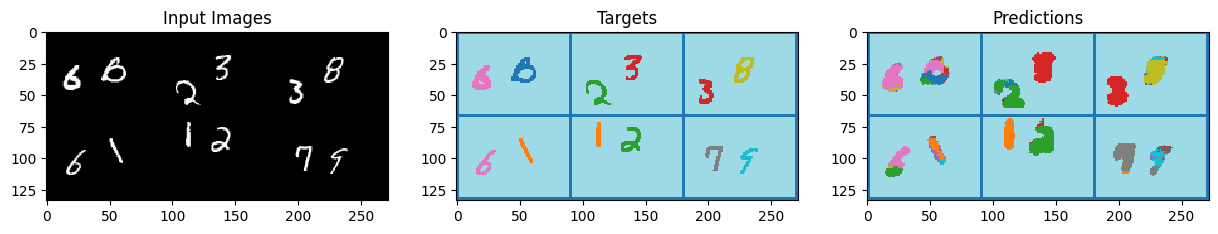

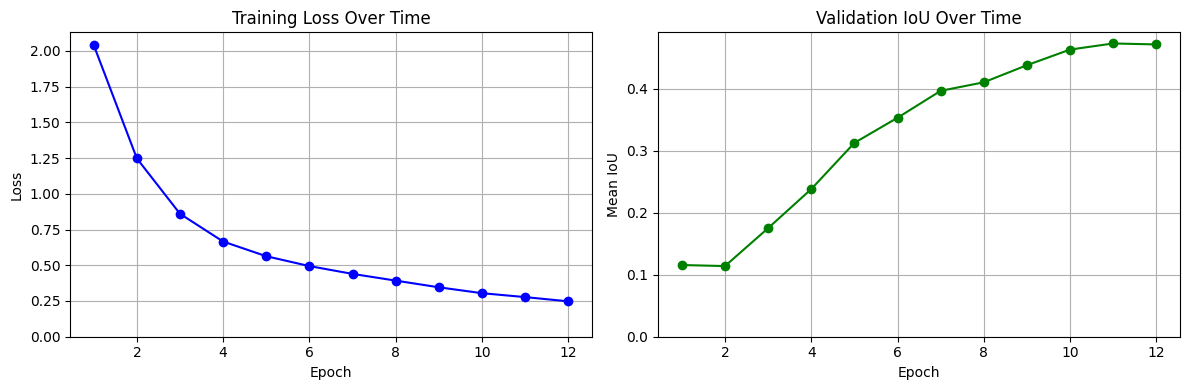

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/24:
Training Loss: 0.2242
Validation IoU (Class: value): 0: 0.4837, 1: 0.4425, 2: 0.4620, 3: 0.4005, 4: 0.3780, 5: 0.3794, 6: 0.5016, 7: 0.4022, 8: 0.3275, 9: 0.2804, 10: 0.9472


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/24:
Training Loss: 0.2245
Validation IoU (Class: value): 0: 0.5156, 1: 0.3567, 2: 0.4549, 3: 0.3529, 4: 0.4400, 5: 0.3751, 6: 0.5104, 7: 0.3323, 8: 0.4120, 9: 0.4193, 10: 0.9463


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/24:
Training Loss: 0.1926
Validation IoU (Class: value): 0: 0.5627, 1: 0.4698, 2: 0.4642, 3: 0.3381, 4: 0.5038, 5: 0.3677, 6: 0.5515, 7: 0.4845, 8: 0.4786, 9: 0.4666, 10: 0.9557


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/24:
Training Loss: 0.1765
Validation IoU (Class: value): 0: 0.4989, 1: 0.4577, 2: 0.4626, 3: 0.4828, 4: 0.4060, 5: 0.5007, 6: 0.5781, 7: 0.4719, 8: 0.5373, 9: 0.4443, 10: 0.9616


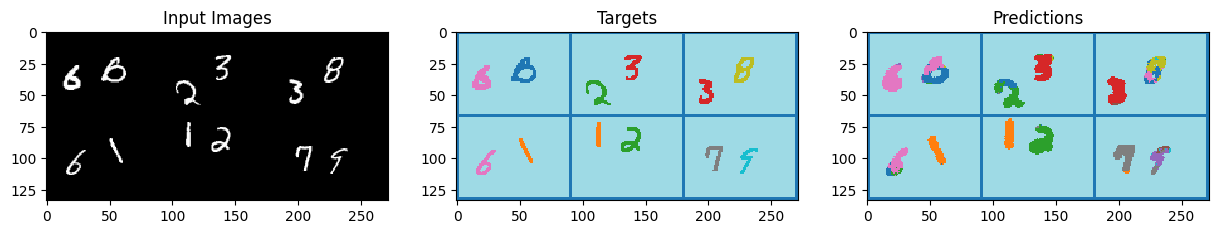

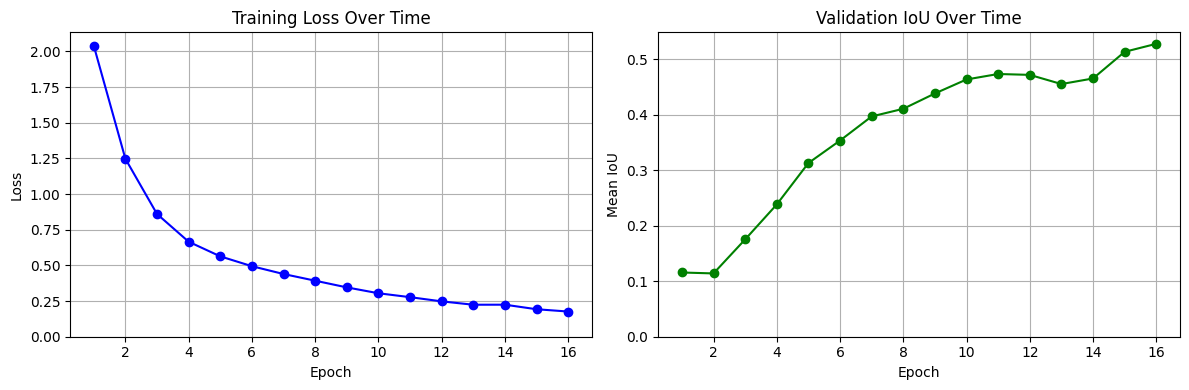

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/24:
Training Loss: 0.1683
Validation IoU (Class: value): 0: 0.5706, 1: 0.4648, 2: 0.5004, 3: 0.4384, 4: 0.4613, 5: 0.4519, 6: 0.5487, 7: 0.4893, 8: 0.5406, 9: 0.4871, 10: 0.9572


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/24:
Training Loss: 0.1595
Validation IoU (Class: value): 0: 0.5652, 1: 0.4629, 2: 0.4906, 3: 0.4089, 4: 0.4892, 5: 0.3497, 6: 0.5626, 7: 0.4646, 8: 0.4965, 9: 0.4711, 10: 0.9568


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/24:
Training Loss: 0.1543
Validation IoU (Class: value): 0: 0.5597, 1: 0.4291, 2: 0.5249, 3: 0.4375, 4: 0.4747, 5: 0.4437, 6: 0.5460, 7: 0.5136, 8: 0.3954, 9: 0.4418, 10: 0.9599


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/24:
Training Loss: 0.1372
Validation IoU (Class: value): 0: 0.5926, 1: 0.5047, 2: 0.5140, 3: 0.4716, 4: 0.5092, 5: 0.4884, 6: 0.5403, 7: 0.5088, 8: 0.5093, 9: 0.5407, 10: 0.9620


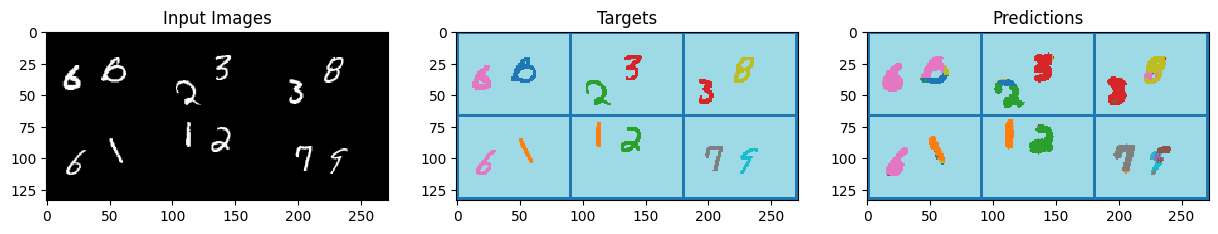

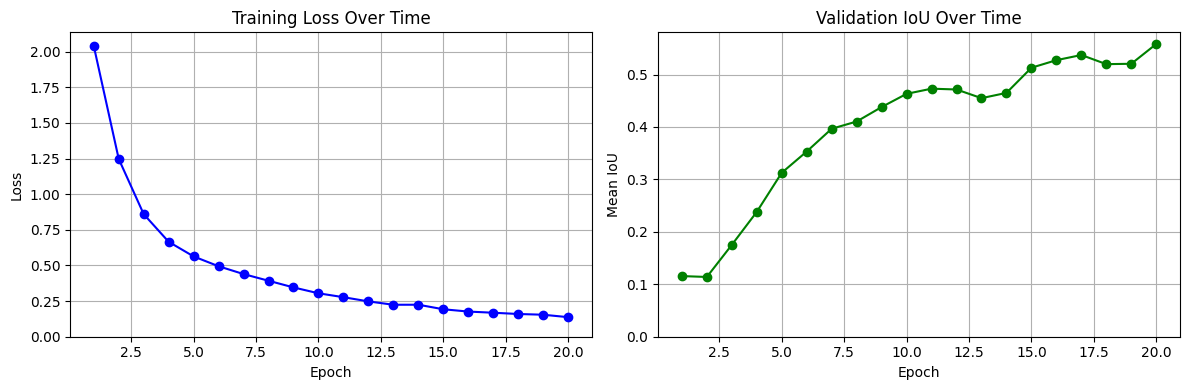

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21/24:
Training Loss: 0.1260
Validation IoU (Class: value): 0: 0.5045, 1: 0.4497, 2: 0.4053, 3: 0.4367, 4: 0.4870, 5: 0.4307, 6: 0.5799, 7: 0.4228, 8: 0.4443, 9: 0.4871, 10: 0.9589


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22/24:
Training Loss: 0.1258
Validation IoU (Class: value): 0: 0.5442, 1: 0.5287, 2: 0.5025, 3: 0.3512, 4: 0.4240, 5: 0.3245, 6: 0.5580, 7: 0.4666, 8: 0.4298, 9: 0.3829, 10: 0.9564


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23/24:
Training Loss: 0.1199
Validation IoU (Class: value): 0: 0.5962, 1: 0.4722, 2: 0.4806, 3: 0.5017, 4: 0.4667, 5: 0.4982, 6: 0.5022, 7: 0.5041, 8: 0.5631, 9: 0.5503, 10: 0.9620


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24/24:
Training Loss: 0.1109
Validation IoU (Class: value): 0: 0.6418, 1: 0.5082, 2: 0.5876, 3: 0.5011, 4: 0.5789, 5: 0.5054, 6: 0.6446, 7: 0.5581, 8: 0.5562, 9: 0.5788, 10: 0.9693


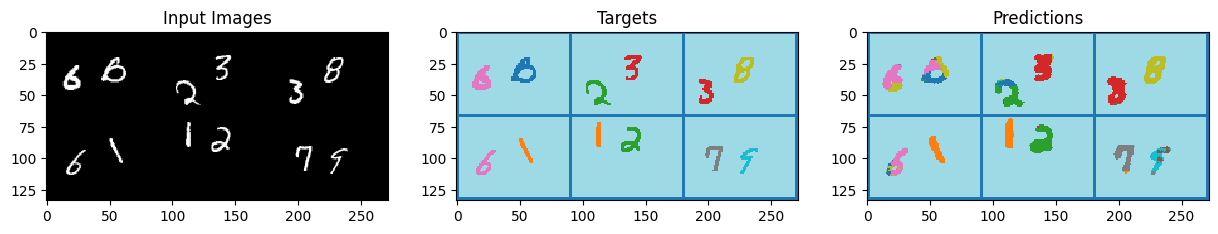

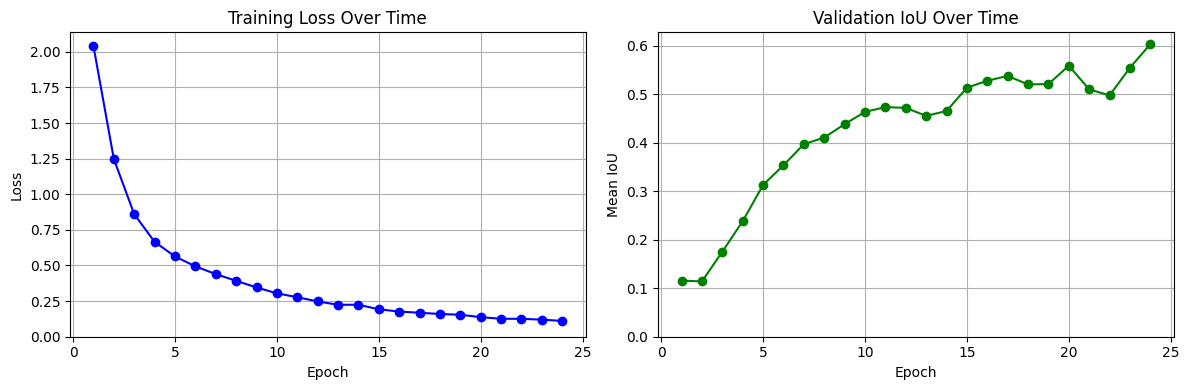

In [6]:
# Hyperparameters
torch.manual_seed(42)

batch_size = 100
learning_rate = 5e-4
num_epochs = 24
disable_skip_connections = True # TRY CHANING ME


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize model and training components
model = UNet(disable_skip_connections=disable_skip_connections).to(device)
criterion = SegmentationLoss(use_weights=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
average_val_ious = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_ious = evaluate(model, val_loader, device)
    train_losses.append(train_loss)
    average_val_ious.append(np.mean(val_ious))

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Training Loss: {train_loss:.4f}')
    val_ious = ', '.join(f'{i}: {iou:.4f}' for i, iou in enumerate(val_ious))
    print(f'Validation IoU (Class: value): {val_ious}')

    # Visualize predictions
    if (epoch + 1) % 4 == 0:
        visualize_prediction(model, val_dataset, [0, 1, 2, 4, 5, 6], device)
        plot_training_metrics(train_losses, average_val_ious)